<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2023/blob/main/notebooks/es7/MetodiAI_Fis2022_Es7_MLP_MNIST_Soluzione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione 7: implementazione in pytorch di una rete neurale fully connected di tipo shallow (un unico layer denso), addestrata per un task di classificazione

**Task:** Scopo: familiarizzare con l'implementazione di ANN con la libreria pytorch

**Dataset:** MNIST benchmark dataset dal repositorio pytorch

In [ ]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


il dataset MNIST è costituito da immagini di caratteri numerici (0,1,...,9) scritti a mano corrispondenti a 60k immagini per il training e 10k immagini per il test.

Ogni immagine ha dimensione $(28,28)$ pixel, con un canale di intensità (scala di grigi) a 8 bit (valori di intensità di ogni pixel $\in [0,256]$).

È disponibile in varie librerie per il ML (scikit-learn, torch, tensorflow, librerie esterne...). Prendendo il dataset già disponibile in pytorch possiamo sfruttare il vantaggio di di avere conversioni automatiche in tensori torch e normalizzazioni. Leggendo il dataset da un input esterno, come per esempio fatto nell'esercitazione su PCA prendendolo da openm, in formato di ndarray numpy, dovremo convertire noi i vettori in tensori torch e normalizzarli, ma risulterà più chiaro come usare in generale datset esterni. in questo hands-on utilizzeremo questo secondo approccio.

In [ ]:
# lettura del dataset MNIST da openml usando la libreria sklearn

from sklearn.datasets import fetch_openml

images, labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) # converte le label in int

print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


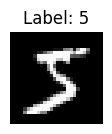

In [ ]:
# grafichiamo una delle immagini del dataset
figure = plt.figure(figsize=(2.2, 1.2))
plt.imshow(images[0].reshape((28,28)), cmap='gray')
plt.title('Label: '+str(labels[0]))
plt.axis("off")
plt.show()

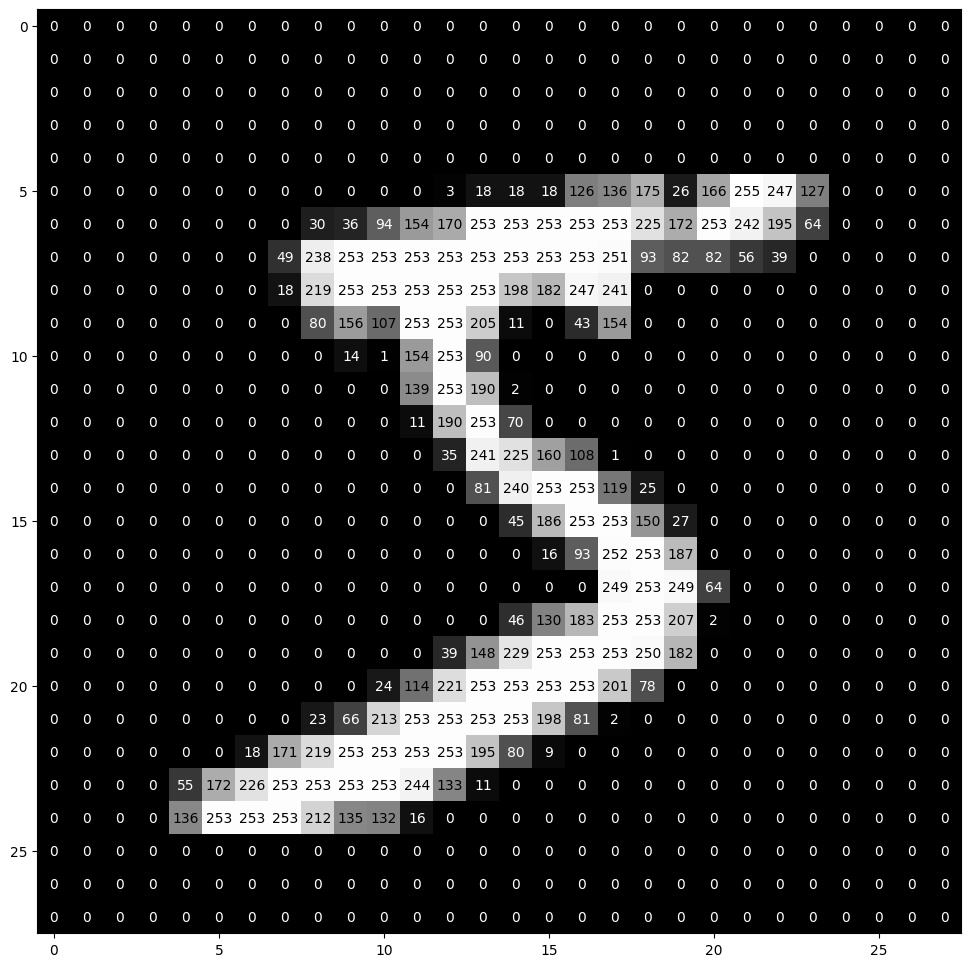

In [ ]:
# come è fatta un'immagine?

img = images[0].reshape((28,28))

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

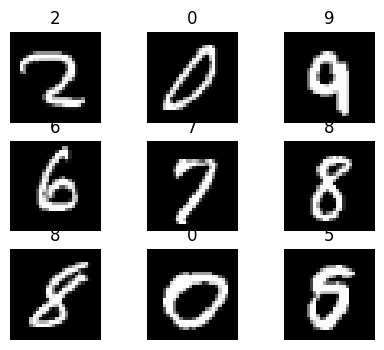

In [ ]:
# grafichiamo 9 immagini random
figure = plt.figure(figsize=(5, 4))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(images))
    img, label = images[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()

**NOTA**: se avessimo voluto usare il dataset MNIST disponibile direttamente in pytorch:

```
from torchvision import datasets
from torchvision.transforms import ToTensor

# la funzione torchvision.datasets.MNIST accede al repositorio torch in cui è presente il dataset MNIST

# il dataset è costituito da immagini in formato PIL (png).
# possono essere convertite automaticamente in tensori torch applicando una "trasformazione" ai dati: torchvision.transforms.ToTensor
# che trasforma l'immagine in un tensore di shape (C,H,W) = (1,28,28) in cui 
# C=canali di colore, H = numero pixel verticali, W = numero pixel orizzontali

train_data = datasets.MNIST(
    root = 'data', #dove andrà a copiare i dataset scaricati
    train = True,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #trasforma i dati letti in tensori torch
    download = True,  #copia fisicamente il dataset sul disco locale (più veloce riaccedere ai dati)        
)

# leggiamo il dataset test
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(train_data)
print(test_data)

# train_data e test_data sono tuple che contengono coppie (immagini convertite in tensori, label)

# si può accedere alle immagini e alle label **originali** (valori dei pixel in [0,255]) tramite i metodi 
.data e .targets

print('Training data shape: ',train_data.data.shape)
print('Training targets shape: ',train_data.targets.shape)
print('Test data shape: ',test_data.data.shape)
print('Test targets shape: ',test_data.targets.shape)

# prima immagine e label del campione di training

immagine = (train_data.data)[0]
label = (train_data.targets)[0]

print(type(immagine)) # tensore torch
print(type(label)) # tensore torch

print('shape immagine: ', immagine.shape)
print('shape immagine: ', immagine.numpy().shape)

print(immagine)
print(label)

# si può anche accedere alle immagini normalizzate in [0,1] direttamente dagli elementi di train_data:

immagine_normalizzata, label_associata = train_data[0]

print(immagine_normalizzata.shape)
```



**Divisione del campione in train, validation e test datasets**: non c'è una regola predefinita, dipende molto dalla dimensione del dataset totale. Tipicamente 60:20:20, ma con grandi dataset si può arrivare a 98:1:1

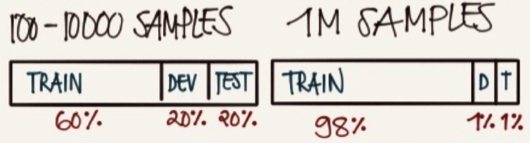

In [ ]:
# splitting del campione in training, validation e test (60:20:20)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.4, shuffle=True, random_state=12345)
X_vali, X_test, Y_vali, Y_test = train_test_split(X_test, Y_test, test_size=0.5, shuffle=True, random_state=456789)
print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(42000, 784)
(42000,)
(14000, 784)
(14000,)
(14000, 784)
(14000,)


**Normalizzazione delle fetaure in input**: normalizzare l'input permette di usare learnign rate più grandi (e quindi effetturare un training più veloce) oltre a stabilizzare l'addestramento ...

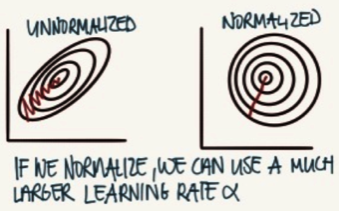

In [ ]:
# le immagini MNIST sono immaginia scala di grigio a 8 bit, ogni pixel assume valore [0,255], quindi in quetso cas è possibile
# normalizzare in [0,1] semplicemnete dividendo tutte le immagini per 255

X_train = X_train / 255.
X_vali  = X_vali / 255.
X_test  = X_test / 255.

In [ ]:
# conversione in tensori torch dei vettori numpy

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([42000, 784])
torch.Size([42000])
torch.Size([14000, 784])
torch.Size([14000])
torch.Size([14000, 784])
torch.Size([14000])


Uso della GPU. Se si ha a disposizione una GPU può essere utilizzata per accelerare le operazioni. Questo richiede di spostare i tensori e il modello di rete neurale sulla GPU quando si effettuano i calcoli. È conveniente controllare se la GPU è disponibile e nel caso settare una variabile opportuna per l'uso successivo.

In [ ]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# per allenare la rete neurale con SGD (stochastic gradient descent), dobbiamo dividere 
# il campione di training in mini batch, e eventualmente fare un reshuffling degli eventi ad ongi epoca, 
# applicare trasformazioni etc... 

# questo viene fatto in pytorch automaticamente tramite delle helper function chiamate 
# Data Sets e Data Loaders 

# pytorch dataset: premette di accoppiare fietaure e target per ogni evento e di accedere ad ogni coppia del 
# dataset

# pytorch dataloader permette di costruire un iterabile python e applicare divisione in mini-batch, shuffling, 
# uso di multiprocessing per leggere i dati, applicare data augmentation, etc....


from torch.utils.data import TensorDataset, DataLoader

batch = 100

dataset_train = TensorDataset(X_train_pt, Y_train_pt) # a datset are pair of feature tensor, target tensor
train_dl = DataLoader(dataset_train, batch_size=batch, shuffle=True, num_workers=1, drop_last=True) #the dataset will be shuffled and batched in mini batch of batch event each

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
vali_dl = DataLoader(dataset_vali, batch_size=batch, shuffle=True, num_workers=1, drop_last=True) 

dataset_test = TensorDataset(X_test_pt, Y_test_pt) 
test_dl = DataLoader(dataset_test, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

Feature batch shape: torch.Size([100, 784])
Labels batch shape: torch.Size([100])
Feature:


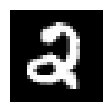

Label: 2


In [ ]:
# ogni data loader fornisce un iteratore con il quale si possono accedere ai vari mini-batch del dataset

feat, label = next(iter(train_dl))

print(f"Feature batch shape: {feat.size()}")
print(f"Labels batch shape: {label.size()}")

an_event = feat[0].view((28,28)) #NOTA: .view è l'equivalente torch di numpy .reshape
a_label = label[0]

figure = plt.figure(figsize=(2.2, 1.2))
print(f"Feature:")
plt.imshow(an_event, cmap='gray')
plt.axis("off")
plt.show()
print(f"Label: {a_label}")

### Definzione del modello di rete neurale.

Archiettura: MLP shallow con layer densi (Linear in pytorch):
 con 1 solo layer hidden con attivazioni ReLU, e 10 neuroni di output con attivazione softmax che predicono la probabilità che l'immagine appartenga ad una delle 10 classi possibili:

*   input layer: 28x28=784 neuroni
*   hidden layer: 1024 neuroni, attivazione ReLU
*   output layer: 10 neuroni, attivazione softmax

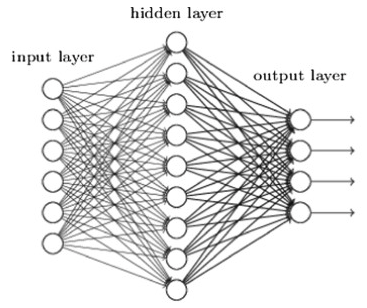

In [ ]:
from torch import nn
import torch.nn.functional as F

# in pytorch una rete neurale viene implementata costruendo una classe python che eredita 
# dalla classe di pytorch nn.Module e implementa due metodi di base:
# __init__: definizione dei layer utlizzati
# forward: funzione che calcola y = ANN(x)

class ShallowMLP(nn.Module):
  def __init__(self, input_dim=784, output_dim=10, hidden_dim=1024):
    super(ShallowMLP, self).__init__()
    
    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, output_dim) #output layer
    
  def forward(self, x):
    x = self.layer1(x)
    x = F.relu(x)
    out = self.layer2(x)
    # NOTA: non applichiamo softmax perché la loss nn.CrossEntropyLoss() già applica automaticamente al suo interno il softmax
    # alternativamente potremmo usare come loss la negative loglikelihood nn.NLLLoss() che non applica il softmax, in questo caso dovremmo 
    # applicare noi il log(softmax) all'output della rete
    #out = F.log_softmax(x, dim=1)
    return out

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# printout del modello

model = ShallowMLP()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,784))
else:
  summary(model, input_size=(1,784))

ShallowMLP(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
            Linear-2                [-1, 1, 10]          10,250
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.11
Estimated Total Size (MB): 3.12
----------------------------------------------------------------


In [ ]:
# testiamo un batch deldataset di train sul modello non addestrato per vedere che le cose funzionino
# è sempre una buona idea ...

feat, label = next(iter(train_dl))

feat=feat.to(device) #sposto sull device il batch di  dati
label=label.to(device) # sposto sull device il batch di label

model.to(device) # sposto il modello sul device 

out = model(feat) #applico il modello (la rete neurale) agli eventi del batch

print('input della rete neurale: ', feat.shape)
print('output della rete neurale: ', out.shape)
print(out[0])

input della rete neurale:  torch.Size([100, 784])
output della rete neurale:  torch.Size([100, 10])
tensor([ 0.0682,  0.0490,  0.0419, -0.1329,  0.0549,  0.0094,  0.0425,  0.0153,
         0.0257, -0.0188], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# Per completare il modello dobbiamo definire la loss function, le eventuali metriche per monitorare il 
# training della rete, e infine l'ottimizzatore

# loss function 
loss_func = nn.CrossEntropyLoss() #cross entropy loss (loss molto usata per classificazione multi classe)
# loss_func = nn.NLLLoss() #alteranativamente con log_softmax (stesso risultato)

# ottmizzatore: usiamo per esempio la discesa stocastica lungo il gradiente con momentum
from torch import optim
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.3 MB/s eta 0:00:00


In [ ]:
# metrica per monitorare il training: accuracy (multiclasse)

import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

metric_func = MulticlassAccuracy(num_classes=10)
metric_func = metric_func.to(device) #NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori

In [ ]:
# vogliamo usare la GPU quindi spostiamo il modello sulla GPU prima della fase di training
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [ ]:
# in pytorch è necessario scriversi il loop di training, cioè il loop sulle epoch di training in cui in ogni 
# epoca si leggono tutti gli eventi del dataset aggiornando i pesi dopo ogni mini-batch

import time

# numero di epoche
epochs = 100

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []


# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0
    for xb, yb in train_dl:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.type(torch.LongTensor).to(device) #copio il mini batch di label sulla CPU/GPU (cuda vuole long int)

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)


        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation (importante!)
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter)

    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in vali_dl:
        counter += 1
        xb=xb.to(device)
        yb=yb.type(torch.LongTensor).to(device)

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= (counter)
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

epoch: 1, time(s): 2.6671, train loss: 1.633876, train metric: 0.667865, vali loss: 0.988414, vali metric: 0.808466
epoch: 2, time(s): 2.5516, train loss: 0.741649, train metric: 0.839023, vali loss: 0.595426, vali metric: 0.857907
epoch: 3, time(s): 2.5874, train loss: 0.524800, train metric: 0.869356, vali loss: 0.478744, vali metric: 0.876825
epoch: 4, time(s): 3.3171, train loss: 0.443685, train metric: 0.883483, vali loss: 0.424655, vali metric: 0.885679
epoch: 5, time(s): 2.5845, train loss: 0.400419, train metric: 0.891743, vali loss: 0.392464, vali metric: 0.893821
epoch: 6, time(s): 2.4894, train loss: 0.372949, train metric: 0.896411, vali loss: 0.371068, vali metric: 0.896993
epoch: 7, time(s): 2.5131, train loss: 0.353200, train metric: 0.899964, vali loss: 0.355919, vali metric: 0.900052
epoch: 8, time(s): 2.6034, train loss: 0.338048, train metric: 0.903655, vali loss: 0.342466, vali metric: 0.900107
epoch: 9, time(s): 3.3443, train loss: 0.325810, train metric: 0.906778,

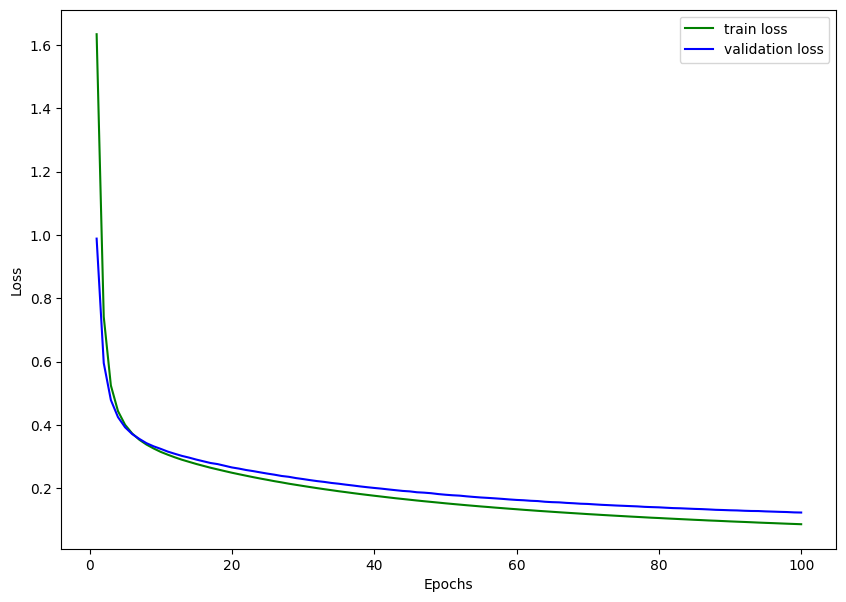

In [ ]:
# grafico loss vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

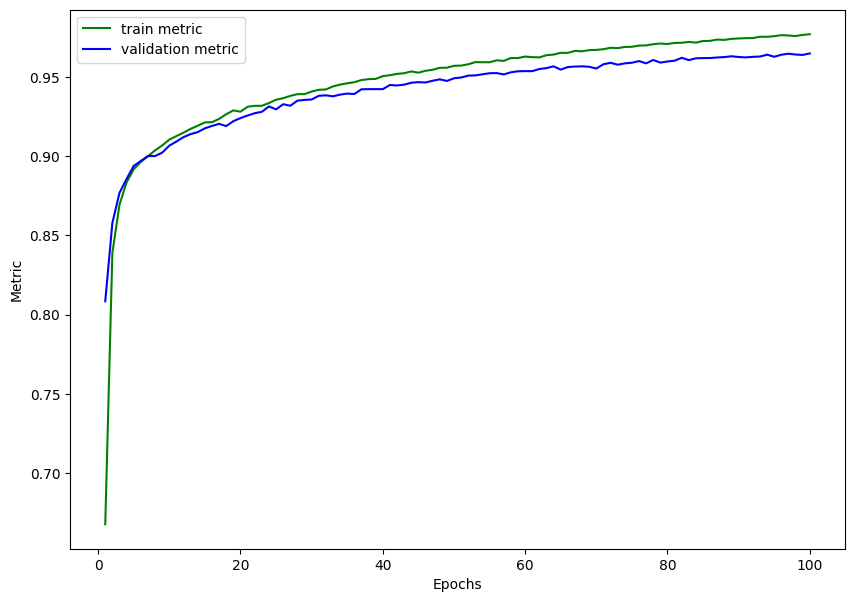

In [ ]:
# grafico accuracy vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
# Salvataggio del modello

torch.save(model, './trained_model.pt')

In [ ]:
# Uso di un modello addestrato in inferenza (predizione) 

# lettura del modello

model = torch.load('./trained_model.pt')
model.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model

# Non è strettamento necessario girare sulla GPU per l'inferenza (richiede minore potenza di calcolo)
model.to(torch.device('cpu'))

metric_func.to(torch.device('cpu'))

loss = 0
metric = 0
counter = 0

for xb, yb in test_dl:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.type(torch.LongTensor).to('cpu')
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += metric_func(pred, yb).item()


loss /= counter
metric /= (counter)

print('Test loss/accuracy: ',loss, ' / ', metric)

Test loss/accuracy:  0.11429789861930269  /  0.9675540349313191


### Compiti:


*   giocate con il codice e i parametri per capire come funziona il tutto, diminuite il numero di neuroni del layer hidden, come decadono le prestazioni della rete in termini di accuracy?
*   provare a cambiare l'attivazione del layer hidden della rete da ReLU a F.tanh o F.sigmoid
*   provare ad aggiungere un secondo e un terzo layer hidden alla rete con 512 neuoroni, come cambiano le prestazioni?
*   provare a giocare con la batch size
*   provare ad eliminare il momentum dall'ottmizzatore SGD e provare diversi valori del learning rate da 0.1 a 0.0001 cosa cambia?
*   provare a cambiare la funzione di ottimizzazione, usando *torch.optim.Adam* con parametri di default, cosa cambia?

